In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lbg_forecast import emulator as em

In [6]:
bands = ["u", "g", "r", "i", "z", "y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

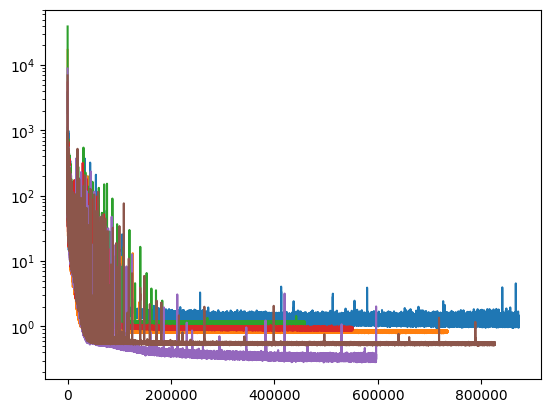

In [7]:
for x in loss_bands:
    plt.plot(x)

plt.yscale("log")

1.231451392173767
0.8381786942481995
1.1343886852264404
0.9336063265800476
0.381106972694397
0.5472787618637085


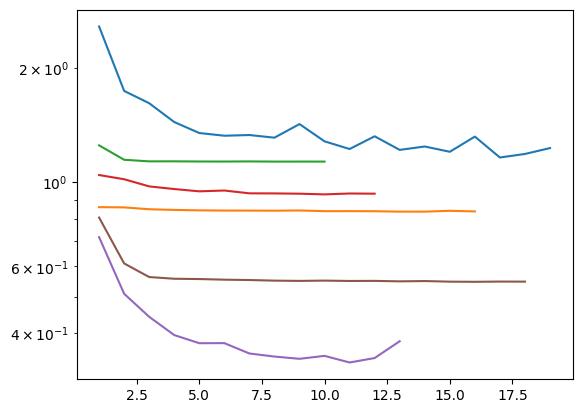

In [8]:
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [ ]:
model = em.fsps_emulator("")